In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf,pacf,arma_order_select_ic
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')
import folium
#color pallette
cnf='#fe9801'
dth='#ff2e63'
rec='#21bf73'
#'''''This module implements a number of iterator building 
#blocks inspired by constructs from APL, Haskell, and SML. Each has been recast in a form suitable for Python.
#The module standardizes a core set of fast, memory efficient tools that are useful by themselves or in combination. 
#Together, they form an 
#iterator algebra” making it possible to construct specialized tools succinctly and efficiently in pure Python
import itertools
import seaborn as sns
import plotly

In [2]:
dataframe=pd.read_excel('C:\\Users\\mypc\\covid_19.xlsx',parse_dates=['Date'])

In [3]:
dataframe['Province/State']=dataframe['Province/State'].fillna('')
dataframe.rename(columns={'Country/Region':'Country','Province/State':'State'},inplace=True)

In [4]:
CDR=dataframe.fillna('').groupby(['Country','Date'])[["Deaths","Confirmed","Recovered"]].sum()
CDR=CDR.groupby(['Country']).max()
CDR=CDR.sort_values(by=['Confirmed','Deaths','Recovered'],ascending=False)
CDR=CDR.head(10)
CDR.rename(index = {"United Kingdom": "UK", }, inplace = True)
CDR.query('Country=="UK"')

,Deaths,Confirmed,Recovered
Country,,,
UK,36124,252246,1134


In [5]:
q=dataframe.query('Country=="Germany"')
qc=q.fillna('').groupby(['Date'])['Confirmed'].max()
qc=pd.DataFrame(qc)
qc

a=dataframe.query('Country=="US"')
ac=a.fillna('').groupby(['Date'])['Confirmed'].max()
ac=pd.DataFrame(ac)
ac

,Confirmed
Date,
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5
...,...
2020-05-17,1486757
2020-05-18,1508308
2020-05-19,1528568


In [6]:
sns.set(palette = 'Set1',style='darkgrid')
#Function for making a time serie on a designated country and plotting the rolled mean and standard 
def roll(country,case='Confirmed'):
    ts=dataframe.loc[(dataframe['Country']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['Confirmed']>=1)])
    ts=ts[-a:]
    return (ts.rolling(window=4,center=False).mean().dropna())


def rollPlot(country, case='Confirmed'):
    ts=dataframe.loc[(dataframe['Country']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['Confirmed']>=1)])
    ts=ts[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(ts[case],label='Confirmed')
    plt.plot(ts.rolling(window=7,center=False).std(),label='Rolling std')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard' %country)
    plt.xticks()

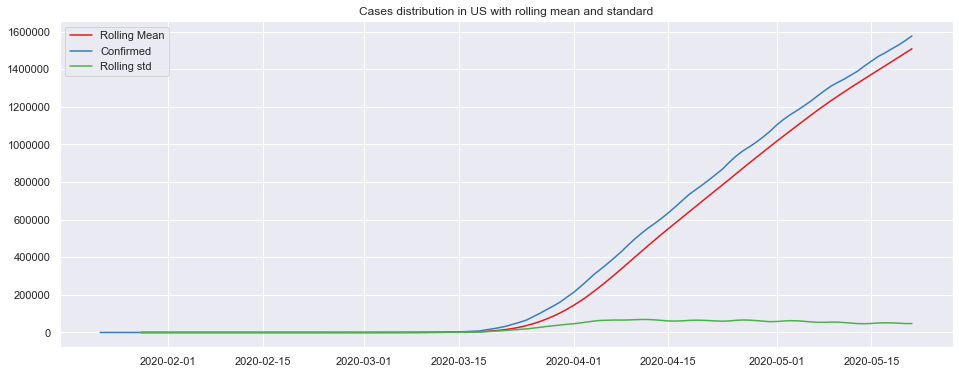

In [7]:
tsC2=roll('US')#US
rollPlot('US')

,Confirmed
Date,
2020-01-30,3.25
2020-01-31,4.25
2020-02-01,5.25
2020-02-02,6.75
2020-02-03,8.75
...,...
2020-05-17,175458.00
2020-05-18,175976.25
2020-05-19,176612.50


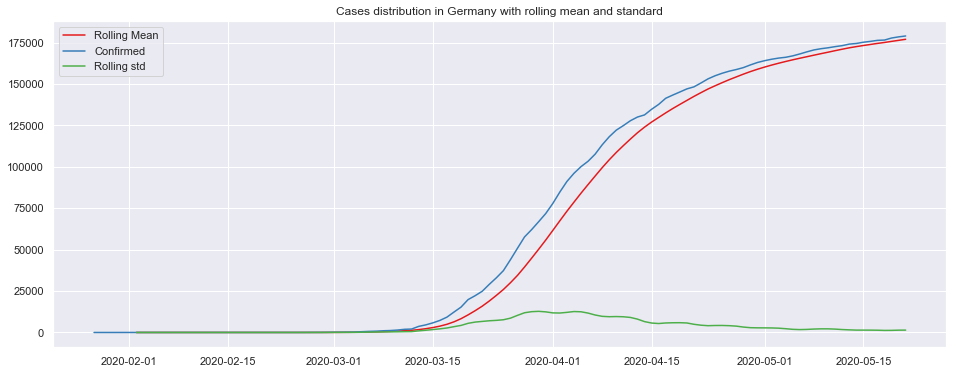

In [8]:
tsC1=roll('Germany')
rollPlot('Germany')
tsC1

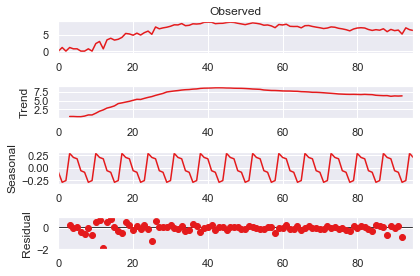

In [25]:
#Decomposing the ts to find its properties
fig=sm.tsa.seasonal_decompose(tsC1.values,period=7).plot()# germany

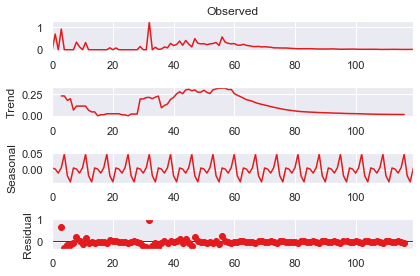

In [26]:
#Decomposing the ts to find its properties
fig=sm.tsa.seasonal_decompose(tsC2.values,period=7).plot()# USA

Results of Dickey-Fuller Test:
Test Statistic                 -3.541779
p-value                         0.006977
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


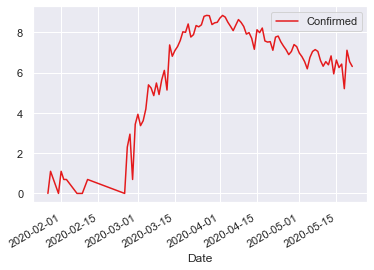

In [27]:
def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

#For Germany the data is not stationary
tsC=tsC1['Confirmed'].values

stationarity(tsC)
tsC1.plot()

Results of Dickey-Fuller Test:
Test Statistic                  -3.633192
p-value                          0.005157
#Lags Used                       2.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


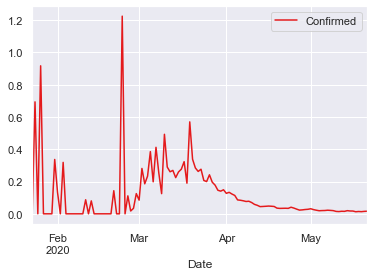

In [28]:
stationarity(tsC2)
tsC2.plot()

# Making Data Stationarity

In [13]:
# for Germany.
qc['Confirmed_diff']=qc['Confirmed'].diff()
qc['Confirmed_diff'].dropna(inplace=True)
qc['Confirm_log_diff']=np.log(qc['Confirmed_diff'])
qc['Confirm_log_diff']=qc['Confirm_log_diff'].replace([np.inf,-np.inf],np.nan)
qc.dropna(inplace=True)
tsC1=qc['Confirm_log_diff']
tsC1=pd.DataFrame(tsC1)
tsC1.rename(columns={'Confirm_log_diff':'Confirmed'},inplace=True)

In [14]:
#For US
ac_log=np.log(ac)

In [15]:
ac_log_diff=ac_log-ac_log.shift(1)
ac_log_diff.dropna(inplace=True)
ac_log_diff
tsC2=ac_log_diff


,Confirmed
Date,
2020-01-23,0.000000
2020-01-24,0.693147
2020-01-25,0.000000
2020-01-26,0.916291
2020-01-27,0.000000
...,...
2020-05-17,0.012819
2020-05-18,0.014391
2020-05-19,0.013343


# Again for checking the Stationarity.

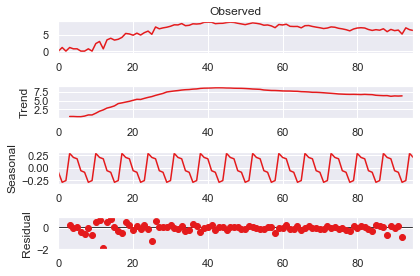

In [16]:
#Decomposing the ts to find its properties
fig=sm.tsa.seasonal_decompose(tsC1.values,period=7).plot()# germany

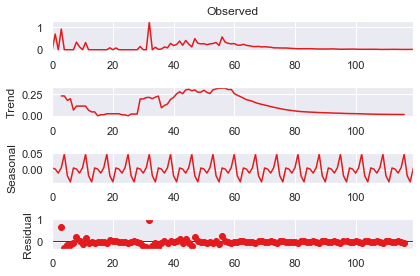

In [17]:
#Decomposing the ts to find its properties
fig=sm.tsa.seasonal_decompose(tsC2.values,period=7).plot()# USA

#Again for the stationarity with the Dickey Fuller.

In [18]:
def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

Results of Dickey-Fuller Test:
Test Statistic                 -3.541779
p-value                         0.006977
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


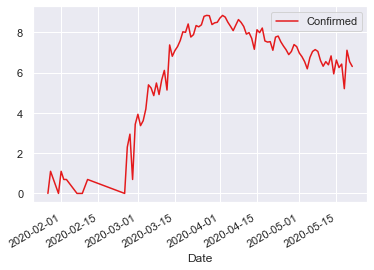

In [19]:
#For Germany the data is not stationary
tsC=tsC1['Confirmed'].values
stationarity(tsC)
tsC1.plot()

In [ ]:
# For the US.

Results of Dickey-Fuller Test:
Test Statistic                  -3.633192
p-value                          0.005157
#Lags Used                       2.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


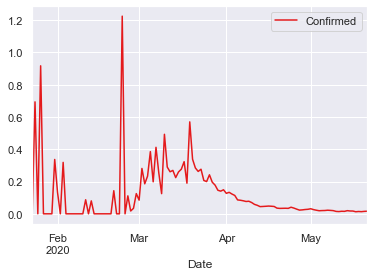

In [20]:
stationarity(tsC2)
tsC2.plot()

# ACF and PCF

In [21]:
def corr(ts):
    plot_acf(ts,lags=12,title="ACF")
    plot_pacf(ts,lags=12,title="PACF")

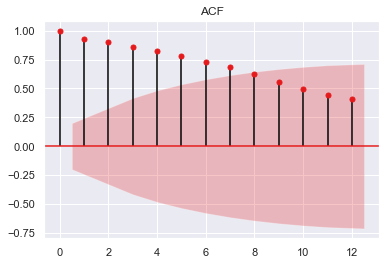

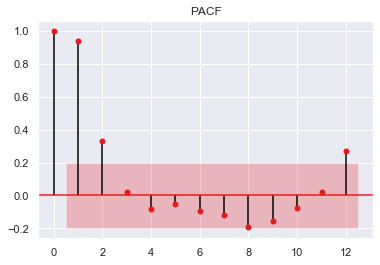

In [22]:
#For Germany
corr(tsC1)

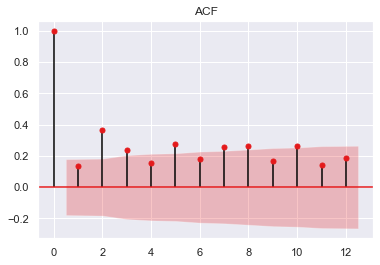

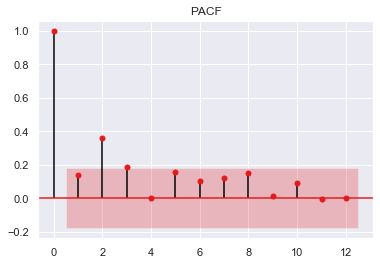

In [23]:
#for US
corr(tsC2)

# Using the Arima Model.

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   74
Model:                 ARIMA(4, 2, 3)   Log Likelihood                 -64.565
Method:                       css-mle   S.D. of innovations              0.538
Date:                Thu, 18 Jun 2020   AIC                            147.130
Time:                        17:26:44   BIC                            167.867
Sample:                             2   HQIC                           155.402
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0056      0.002     -3.398      0.001      -0.009      -0.002
ar.L1.D2.y    -2.0524      0.114    -18.002      0.000      -2.276      -1.829
ar.L2.D2.y    -2.0888      0.236     -8.836      0.0

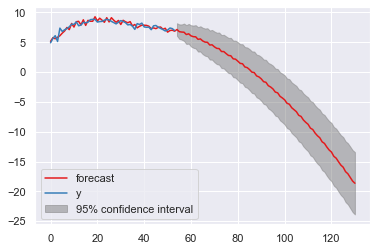

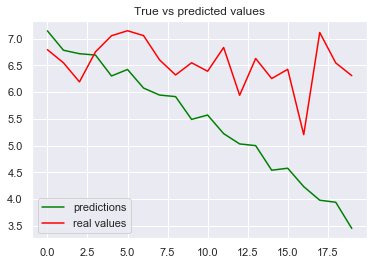

In [29]:
#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.80)
    train_set= ts[:size]
    test_set = ts[size:]
    return(train_set,test_set)


#Arima modeling for ts
def arima(ts,test_set):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.30), end=int(len(ts) * 2))
    pred=result.forecast(steps=len(test_set))[0]
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test_set, c='red',label='real values')
    plt.legend()
    plt.title('True vs predicted values')
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean absolute percentage error: %f'%mape(test_set,pred))
    return (pred)



train_set,test_set=split(tsC)
pred=arima(train_set,test_set)